In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mrmr import mrmr_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Pre-processing

## Load data

In [3]:
X = pd.read_csv("../features.csv", sep=";")
y = pd.read_csv("../../labels.csv", sep=";")
y = y.loc[y["Sample"].isin(X["Sample"])].set_index("Sample", drop=True)["Label"]
X = X.set_index("Sample", drop=True)
X.shape

(172, 8889)

## Remove features with less than n% unique values

In [152]:
# Calculate the percentage of unique values for each feature
unique_percentages = (X.nunique() / X.shape[0]) * 100

# Identify features with more than 90% same values
features_to_drop = unique_percentages[unique_percentages < 90].index

# Remove the identified features from the DataFrame
filtered_X = X.drop(features_to_drop, axis=1)
filtered_X.shape

(172, 512)

## MRMR to select k features 

In [235]:
selected_features = mrmr_classif(X=filtered_X, y=y, K=100)
X[selected_features]

100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


,Caproicibacterium lactatifermentans,Parabacteroides johnsonii,Candidatus Nanosynbacter sp. HMT-352,Acidaminococcus intestini,Ruminococcus bicirculans,Streptococcus australis,Bacteroides cellulosilyticus,Megasphaera stantonii,Adlercreutzia equolifaciens,Paraprevotella xylaniphila,...,Butyrivibrio crossotus,Bacteroides faecium,Rhodopseudomonas palustris,Olsenella timonensis,Caproicibacter fermentans,Streptococcus salivarius,Salinibacter ruber,Clostridium cadaveris,Berryella wangjianweii,Butyricimonas faecalis
Sample,,,,,,,,,,,,,,,,,,,,,
SRR15595350,584,574,53.0,156,1668,8,1098,227,1473,10556,...,3550,1372,118,918,596,218,83,440,322,644
SRR15595341,241,183,58.0,98,33160,24,13505,97,520,1842,...,1079,500,55,877,278,2429,20,176,129,287
SRR15595330,311,249,187.0,79,8168,29,1954,133,6157,4663,...,2607,913,60,566,199,1163,96,1985,84,942
SRR15595319,469,170,58.0,81,9135,68,142,69,898,56,...,2950,34,48,120,355,12270,44,251,101,22
SRR15595315,424,5126,27.0,198,11850,362,386,96,16971,42,...,1227,137,127,769,393,9709,47,214,205,172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR22402268,882,17119,338.0,812,1058,2323,7164,1215,558,984,...,8791,9917,237,538,1311,226344,131,2390,175,52687
SRR22402267,1259,148047,1775.0,490,3440,2682,429190,779,15263,380620,...,31580,25630,206,2379,1287,19753,114,1843,479,8498
SRR22402325,1504,137405,947.0,433,7551,4384,3325315,1180,27621,151898,...,62789,36809,347,1776,2245,11624,172,3532,457,4832


In [254]:
corr_df = X.join(y)
corr_m = corr_df.corr()["Label"]
corr_m[abs(corr_m) > 0.5]

Label    1.0
Name: Label, dtype: float64

### Cumulative explained variance

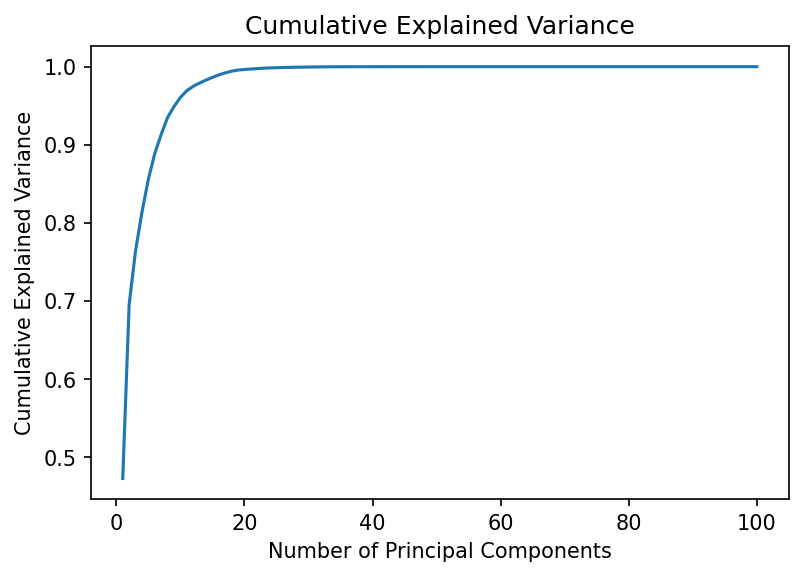

In [239]:
# Perform PCA
pca = PCA()
pca.fit(X[selected_features])
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
fig = plt.figure(dpi=150)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

## Split the data

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Models

## Logistic regression

In [252]:
pipeline = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),
    ('min_max_scale', MinMaxScaler()),
    ('logreg', LogisticRegression(random_state=42))
])

Accuracy: 0.7142857142857143
Best score:  0.723015873015873


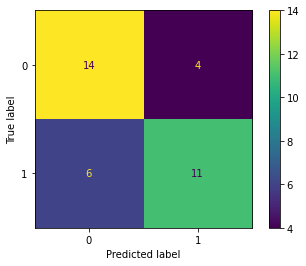

{'logreg__C': 0.9}

In [253]:
# define the hyperparameters to search over
param_grid = {
    'logreg__C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}

# perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)
# Get the best estimator and make predictions on the testing data
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print('Best score: ', grid_search.best_score_)

cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
grid_search.best_params_

## Random forest

In [228]:
# Define the Pipeline
rf_pipeline = Pipeline([
    # ('variance_filter', VarianceThreshold()), # Step 0: filter out variables with variance < threshold
    ('log_transform', FunctionTransformer(np.log1p)),  # Step 1: log transformation
    ('min_max_scaler', MinMaxScaler()),  # Step 2: min-max scaling
    ('pca', PCA()),  # Step 3: PCA
    ('rf', RandomForestClassifier(random_state=42, warm_start=True))  # Step 4: Random Forest
])

Accuracy: 0.6
Best score: 0.6198412698412699


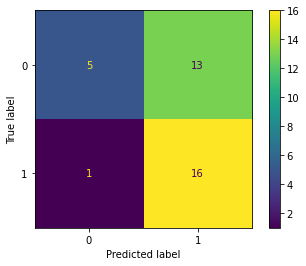

{'pca__n_components': 1,
 'rf__criterion': 'gini',
 'rf__max_depth': 1,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 3}

In [229]:
# #Define the parameter grid for grid search
# param_grid = {
#     'variance_filter__threshold': [0.0, 0.1, 0.2, 0.3, 0.4], # grid search value for variance filter threshold
#     'pca__n_components': [1, 5, 10, 15, 20, 25, 30],  # Step 3:grid search number of components
#     'rf__n_estimators': [100, 150, 200, 250, 300, 350],  # Step 4: grid search for n_estimators
#     'rf__max_depth': [25, 50, 100, 200, 250, 300, None],  # Step 4: grid search for max_depth
#     'rf__criterion' :['gini', 'entropy', 'log_loss'], # Step 4: grid search for criterion
#     'rf__max_features': ['sqrt', 'log2'], # Step 4: grid search for number of max_features
# }
rf_param_grid = {
    # 'variance_filter__threshold': [0.1], # grid search value for variance filter threshold
    'pca__n_components': [1,2,3,4,5],  # Step 3:grid search number of components
    'rf__n_estimators': [1,2,3,4,5],  # Step 4: grid search for n_estimators
    'rf__max_depth': [1,2,3,4,5],  # Step 4: grid search for max_depth
    'rf__criterion' :['gini', 'entropy', 'log_loss'], # Step 4: grid search for criterion
    'rf__max_features': ['sqrt', 'log2'], # Step 4: grid search for number of max_features
}

# Define the GridSearchCV object
rf_grid_search = GridSearchCV(rf_pipeline, param_grid=rf_param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on the training data
rf_grid_search.fit(X_train, y_train)

# Get the best estimator and make predictions on the testing data
best_estimator = rf_grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Best score:", rf_grid_search.best_score_)

cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
rf_grid_search.best_params_